# Kinetic MWC Model without Explicit Ligand Dynamics
### Maxim Zewe at AMOLF in Fall 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numba
from numba import jit
import scipy.optimize as spopt
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
import animatplot as amp

In [2]:
# define some colours to use throughout for plotting
my_red = '#CD5C5C'
my_blue = '#5D8AA8'
my_yellow = '#ED9121'
my_green = '#708238'
colormap = matplotlib.colormaps.get_cmap('coolwarm')
colormap_2 = matplotlib.colormaps.get_cmap('tab10')

In [3]:
# set the events with the corresponding rates
@numba.jit(nopython=True)
def propensities(state,c,methylation,activation,N,
                delta_f=-2,Ki=18,Ka=2900,kR=0.075,kB=0.15,kAct=50):
    # arrays to store results
    rates = np.zeros(2)
    events = np.zeros((2,2))

    # calculate free-energy difference
    mbase = N/2
    f = N*np.log((1 + c/Ki)/(1 + c/Ka)) + delta_f*(state[1] - mbase)

    # set rate constants for (de)activation
    kDeact = kAct*np.exp(f)

    # check methylation states
    mMax = 4*N
    meth_ceiling = state[1] < mMax
    meth_floor = state[1] > 0

    # for inactive cluster
    if state[0] == 0:
        # methylation; only possible if a site is available
        rates[0] = kR*meth_ceiling*methylation
        events[0] = [0,1]

        # activity switching
        rates[1] = kAct*activation
        events[1] = [1,0]

    # for active cluster
    else:
        # demethylation; only possible if a site is occupied
        rates[0] = kB*meth_floor*methylation
        events[0] = [0,-1]

        # deactivation
        rates[1] = kDeact*activation
        events[1] = [-1,0]
        
    return rates, events

# function to draw a biased sample in numba
@numba.jit(nopython=True)
def biased_choice(outcomes,prob):
    return outcomes[np.searchsorted(np.cumsum(prob), np.random.rand(1))]

# function to implement Gillespie's direct algorithm
@numba.jit(nopython=True)
def gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,
                    Nr=6,methylation=True,activation=True,cbase=100):
    # set up arrays to hold the results
    t_grid = np.linspace(0,tf,n_steps+1)
    all_states = np.zeros((n_sims,n_steps+1,2))

    ############# actual algorithm #############
    
    for i in range(n_sims):
        # initialise each realisation
        a0 = biased_choice(np.array([0.,1.]),np.array([2/3,1/3]))[0]
        state = np.array([a0, m0])
        all_states[i,0,0] = a0
        all_states[i,0,1] = m0
        dt = 0
        time = 0
        
        # loop over all time steps
        for j in range(n_steps):
            # change concentration after step_change time steps
            if j >= step_change:
                c = cnew
            else:
                c = cbase
                
            # ensure initialisation; not necessary after initial round
            if time == 0:
                # set state to extract rates and propensities
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # keep updating until we reach the end of the interval
            while time < t_grid[j]:                
                # extract rates and propensities for next round
                state = state + events[event_idx]
                rates, events = propensities(state,c,methylation,activation,Nr)

                # determine which event occurs
                p = np.random.uniform(0,1)*np.sum(rates)
                mask = p < np.cumsum(rates)
                event_idx = np.where(mask == True)[0][0]

                # this samples the time until the next event
                u = np.random.uniform(0,1)
                dt = -np.log(u)/np.sum(rates)
                time += dt
                
            # save the last state before passing the boundary
            all_states[i,j+1,:] = state
            
    ############ averaging ############
    
    av_states = np.zeros((n_steps+1,2))
    
    # averaging in the awkward numba way
    for j in range(n_steps+1):
        for k in range(2):
            av_states[j,k] = np.mean(all_states[:,j,k])
            
    # normalise
    mMax = 4*Nr
    av_states[:,1] = av_states[:,1]/mMax
            
    return all_states, av_states, t_grid

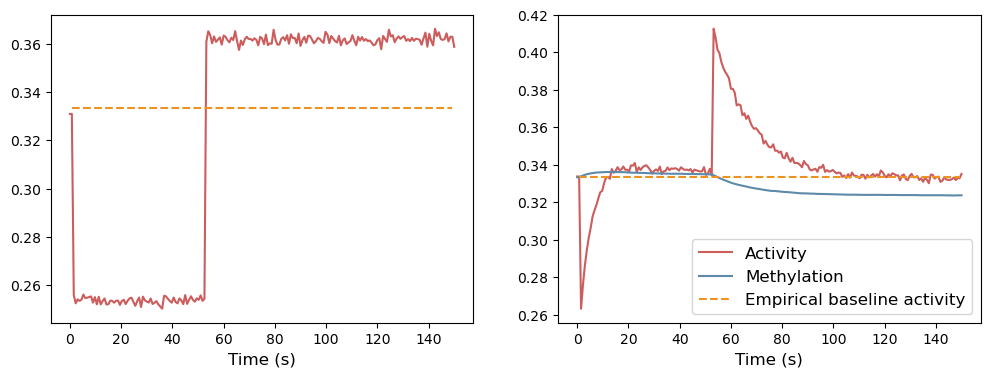

In [4]:
# check that the algorithm works
m0 = 8.
tf = 150
n_steps = 200
n_sims = 10**5
step_change = 70
cnew = 90

# prepare figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

####################
## No methylation ##
####################

# extract results and standard deviations
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
sem = np.std(all_states[:,:,0],axis=0)

ax1.plot(time,results[:,0],color=my_red,label='Activity')
#ax1.fill_between(time,results[:,0]-sem,results[:,0]+sem,color=my_red,alpha=0.2)
ax1.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle='--',color=my_yellow,label='Empirical baseline activity')
ax1.set_xlabel('Time (s)',size=12)

######################
## With methylation ##
######################

# extract results and standard deviations
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=True)
sem_act = np.std(all_states[:,:,0],axis=0)/np.sqrt(n_sims)
sem_meth = np.std(all_states[:,:,1]/24,axis=0)/np.sqrt(n_sims)

ax2.plot(time,results[:,0],color=my_red,label='Activity')
#ax2.fill_between(time,results[:,0]-sem_act,results[:,0]+sem_act,color=my_red,alpha=0.2)
ax2.plot(time,results[:,1],color=my_blue,label='Methylation')
#ax2.fill_between(time,results[:,1]-sem_meth,results[:,1]+sem_meth,color=my_blue,alpha=0.2)
ax2.axhline(y=1/3,xmin=0.05,xmax=0.95,linestyle='--',color=my_yellow,label='Empirical baseline activity')
ax2.set_xlabel('Time (s)',size=12)
ax2.legend(fontsize=12,loc='lower right')

plt.show()

In [5]:
# check how fast the algorithm is
m0 = 8.
tf = 100
n_steps = 160
n_sims = 10**2
step_change = 80
cnew = 90

%timeit gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=True)

296 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Running the algortihm $10^4$ under these conditions would take about 30 s.  

## Dose-response curve

In this section, we use the simulation to extract the dose-response curve. The procedure is as follows. We turn methylation off to prevent adaptation. After equilibration, the cluster receives a step increase in concentration, upon which the activity settles to a new equilibrium. We measure the amplitude of the response as the difference between the activity just before the change in concentration and the new equilibrium activity, which we take from the last point of the simulation. Repeating this procedure for various values of the final concentration allows us to extract a dose-response curve. 

The aim here is not to replicate any measured dose-response curve. Instead, the aim is to reproduce some qualitative characteristics of a typical dose-response curve extracted from an MWC model, such as its sigmoidal shape. This would provide evidence that our model agrees with the non-dynamical MWC model.

In [6]:
# function to compute theoretical drc
@numba.jit(nopython=True)
def theoretical_drc(cnew_arr,
                    N=6,c0=100,delta_f=-2,Ki=18,Ka=2900):
    # calculate free-energy difference
    m0=0.5*(N+N*np.log((1+100/18)/(1+100/2900)))
    mbase = N/2.
    f0 = N*np.log((1 + c0/Ki)/(1 + c0/Ka)) + delta_f*(m0 - mbase)
    fc = N*np.log((1 + cnew_arr/Ki)/(1 + cnew_arr/Ka)) + delta_f*(m0 - mbase)
    
    # calculate average activities
    a_pre = 1/(1 + np.exp(f0))
    a_post = 1/(1 + np.exp(fc))
    
    # return response
    return a_post-a_pre

# function to simulate drc
@numba.jit(nopython=True)
def drc(cnew_arr,
        m0=3+3*np.log((1+100/18)/(1+100/2900)),tf=100,n_steps=200,step_change=100,n_sims=10**3):
    # array to store results
    all_responses = np.zeros((cnew_arr.size,n_sims),dtype='float32')
    
    # loop through various final concentrations
    for i,cnew in enumerate(cnew_arr):
        # obtain activity
        all_states,_,_ = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
        
        # loop through all realisations
        for sample in range(n_sims):
            # pre-stimulus activity
            a_pre = np.mean(all_states[sample,step_change-51:step_change-1,0])
            
            # post-stimulus activity
            a_post = np.mean(all_states[sample,-50:,0])
            
            # save the responses
            all_responses[i,sample] = a_post-a_pre
            
    return all_responses

# Hill function used for fitting
def hill_function(c,nH):
    c0 = 100
    return c**nH/(c0**nH + c**nH) - 0.5

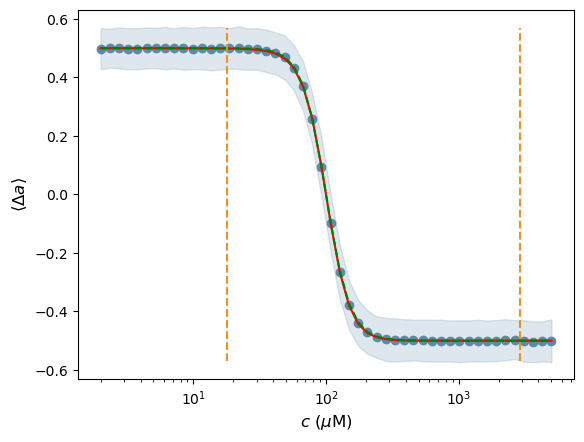

Hill coeff. -4.835320159877892  +/- 0.0209348429002676


In [7]:
# find responses
cnew_arr = np.logspace(0.3,3.7,50)
responses = drc(cnew_arr)

# extract means and error bars
mean_responses = np.mean(responses,axis=1)
sem_responses = np.std(responses,axis=1)

# perform fitting
popt, pcov = curve_fit(hill_function,cnew_arr,mean_responses,sigma=sem_responses)

# plot the results
plt.semilogx(cnew_arr,np.mean(responses,axis=1),'o',color=my_blue,label='Simulation')
plt.semilogx(cnew_arr,theoretical_drc(cnew_arr),color='r',label='Theory')
plt.semilogx(cnew_arr,hill_function(cnew_arr,*popt),color='g',ls='--',label='Hill function')
plt.fill_between(cnew_arr,mean_responses-sem_responses,mean_responses+sem_responses,color=my_blue,alpha=0.2)
plt.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color=my_yellow)
plt.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color=my_yellow,label=r'$K_I,\, K_A$')
plt.xlabel(r'$c$ ($\mu$M)',size=12)
plt.ylabel(r'$\langle \Delta a \rangle$',size=12)
#plt.legend(fontsize=12)
plt.show()

print('Hill coeff.', popt[0],' +/-', np.sqrt(pcov[0,0]))

## Non-adaptive kernel

In the absence of methylation, the cell does not adapt. In response to a step change in the concentration, the response function of the cell can be described by
$$ K^*(t) = G(1-e^{-t/\tau_r}),$$
for some gain $G$ and response time $\tau_r$. This response is the activity rescaled by $\ln(c_0/c)$. Note that the activity is downshifted by its baseline level before $K^*(t)$ is computed. As such, $G$ essentially measures the same as $\Delta a$, because $G = \lim_{t\to \infty} K^*(t)$. To be sure, we simulate $K^*(t)$ for a few concentrations and compare the $G$ we find through fitting to the theoretical result.

In [8]:
# define model function
def Kstar(t,G,taur):
    return G*(1 - np.exp(-t/taur))

# function for extracting the response
def response_kernel_star(all_states,step_change,time,cnew=90):
    # extract mean
    activity = np.mean(all_states[:,:,0],axis=0)
    
    # find response and shift time
    baseline = np.mean(activity[step_change-101:step_change-1])
    response = (activity[step_change-1:] - baseline)/np.log(100/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sd_resp = np.std(all_states[:,step_change-1:,0],axis=0)/np.log(100/cnew)
    
    # perform fitting
    popt, pcov = curve_fit(Kstar,shifted_time,response,p0=[1,0.06],sigma=sd_resp)
        
    # return the fitting parameters and their uncertainties
    return response, shifted_time, popt, [np.sqrt(pcov[i,i]) for i in range(2)]

Hill coeff. -4.8759468688168095  +/- 0.034928736019896704


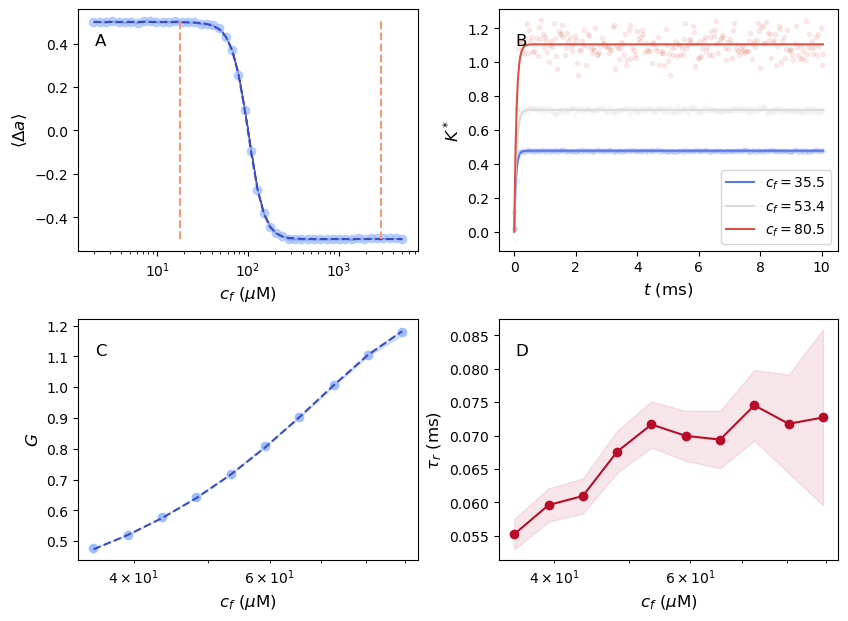

In [9]:
# preparation
fig = plt.figure(figsize=(17,12))
colormap = matplotlib.colormaps.get_cmap('coolwarm')
gs = gridspec.GridSpec(4, 4)

#########
## DRC ##
#########

# find responses
cnew_arr = np.logspace(0.3,3.7,50)
responses = drc(cnew_arr)

# extract means and error bars
mean_responses = np.mean(responses,axis=1)
sem_responses = np.std(responses,axis=1)/np.sqrt(responses[0,:].size)

# perform fitting
popt, pcov = curve_fit(hill_function,cnew_arr,mean_responses,sigma=sem_responses)
print('Hill coeff.', popt[0],' +/-', np.sqrt(pcov[0,0]))

ax1 = fig.add_subplot(gs[0,0])

# plot the results
ax1.semilogx(cnew_arr,np.mean(responses,axis=1),'o',color=colormap(0.3),label='Simulation',alpha=0.7)
ax1.semilogx(cnew_arr,theoretical_drc(cnew_arr),'--',color=colormap(0.),label='Theory')
ax1.fill_between(cnew_arr,mean_responses-sem_responses,mean_responses+sem_responses,color=colormap(0),alpha=0.9)
ax1.axvline(x=18,ymin=0.05,ymax=0.95,ls='--',color=colormap(0.75))
ax1.axvline(x=2900,ymin=0.05,ymax=0.95,ls='--',color=colormap(0.75),label=r'$K_I,\, K_A$')
ax1.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax1.set_ylabel(r'$\langle \Delta a \rangle$',size=12)
ax1.text(0.05,0.85,'A',size=12,transform = ax1.transAxes)

######################
## Response kernels ##
######################

# parameters
m0 = 3+3*np.log((1+100/18)/(1+100/2900))
tf = 400
n_steps = 10**4
n_sims = 10**3
step_change = 9750

# prep
cnew_arr = np.logspace(1.55,1.95,10)
all_parms = np.zeros((cnew_arr.size,2),dtype='float32')
all_err = np.zeros_like(all_parms)
colormap = matplotlib.colormaps.get_cmap('coolwarm')

ax2 = fig.add_subplot(gs[0,1])

for i,cnew in enumerate(cnew_arr):
    # obtain data
    all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False)
    response, shifted_time, popt, sds = response_kernel_star(all_states,step_change,time,cnew=cnew)
    all_parms[i,:] = popt
    all_err[i,:] = sds
    
    # choose a colour
    random_color = colormap(i/cnew_arr.size + 0.1)
    
    if i % 4 == 0:
        # show kernel with data
        ax2.plot(shifted_time,Kstar(shifted_time,*popt),color=random_color,label=f'$c_f={np.round(cnew,1)}$')
        ax2.plot(shifted_time,response,'.',color=random_color,alpha=0.1)

# formatting 
ax2.legend(fontsize=10)
ax2.text(0.05,0.85,'B',size=12,transform = ax2.transAxes)
ax2.set_xlabel(r'$t$ (ms)',size=12)
ax2.set_ylabel(r'$K^*$',size=12)

# show kernel parameters
ax3 = fig.add_subplot(gs[1,0])
ax3.semilogx(cnew_arr,all_parms[:,0],'o',color=colormap(0.3))
ax3.semilogx(cnew_arr,theoretical_drc(cnew_arr)/np.log(100/cnew_arr),'--',color=colormap(0.))
ax3.fill_between(cnew_arr,all_parms[:,0]-all_err[:,0],all_parms[:,0]+all_err[:,0],color=colormap(0.3),alpha=0.4)
ax3.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax3.set_ylabel(r'$G$',size=12)
ax3.text(0.05,0.85,'C',size=12,transform = ax3.transAxes)

ax4 = fig.add_subplot(gs[1,1])
ax4.semilogx(cnew_arr,all_parms[:,1],'-o',color=colormap(0.99))
ax4.fill_between(cnew_arr,all_parms[:,1]-all_err[:,1],all_parms[:,1]+all_err[:,1],color=colormap(0.99),alpha=0.1)
ax4.set_xlabel(r'$c_f$ ($\mu$M)',size=12)
ax4.set_ylabel(r'$\tau_r$ (ms)',size=12)
ax4.text(0.05,0.85,'D',size=12,transform = ax4.transAxes)

plt.tight_layout()
plt.show()

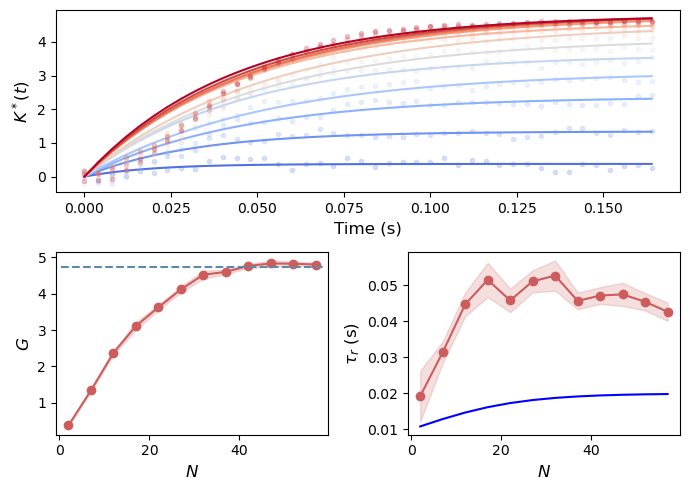

In [87]:
# check how the gain depends on N
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# theoretical prediction for tau_r
def theory_tau_r(N,c,c0=100,Ki=18,Ka=2900,kAct=50,delta_fm=-2):
    mbase = N/2.
    # set baseline energy
    m0 = mbase-(N/delta_fm)*np.log((1+c0/Ki)/(1+c0/Ka))
    
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + delta_fm*(m0-mbase)
    return 1/(kAct*(1+np.exp(F)))

# parameters
tf = 40
n_steps = 10000
n_sims = 1000
step_change = 9960
cnew = 90
N_arr = np.arange(2,60,5)
kernel_parms = np.zeros((2,N_arr.size),dtype='float64')
kernel_sds = np.zeros_like(kernel_parms)

for n,N in enumerate(N_arr):
    # set baseline energy
    m0 = N*(0.5+0.5*np.log((1+100/18)/(1+100/2900)))
    
    # obtain data and fit
    all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False,Nr=N)
    response, shifted_time, popt, sds = response_kernel_star(all_states,step_change,time,cnew=cnew)
    
    # show the fit
    color = colormap((n+1)/N_arr.size)
    ax1.plot(shifted_time,Kstar(shifted_time,*popt),color=color,label=f'$N={N}$')
    ax1.plot(shifted_time,response,'.',color=color,alpha=0.2)
    
    # store gain and response time
    kernel_parms[:,n] = popt
    kernel_sds[:,n] = sds

# formatting ax1
#ax1.legend(ncol=3)
ax1.set_ylabel(r'$K^*(t)$',size=12)
ax1.set_xlabel(r'Time (s)',size=12)

# show how the gain and response time depend on N
for i,ax in enumerate((ax2,ax3)):
    ax.plot(N_arr,kernel_parms[i,:],'-o',color=my_red)
    ax.fill_between(N_arr,kernel_parms[i,:]-kernel_sds[i,:],kernel_parms[i,:]+kernel_sds[i,:],
                    alpha=0.2,color=my_red)
    ax.set_xlabel(r'$N$',size=12)
    
ax2.axhline(y=0.5/np.log(100/cnew),xmin=0.02,xmax=0.98,ls='--',color=my_blue)
ax2.set_ylabel(r'$G$',size=12)
ax3.plot(N_arr,theory_tau_r(N_arr,cnew),color='b')
ax3.set_ylabel(r'$\tau_r$ (s)',size=12)

plt.tight_layout()
plt.show()

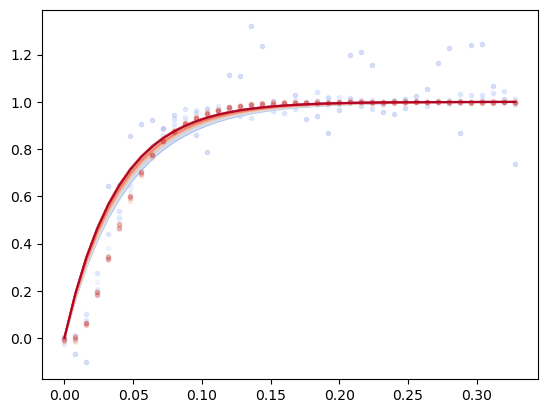

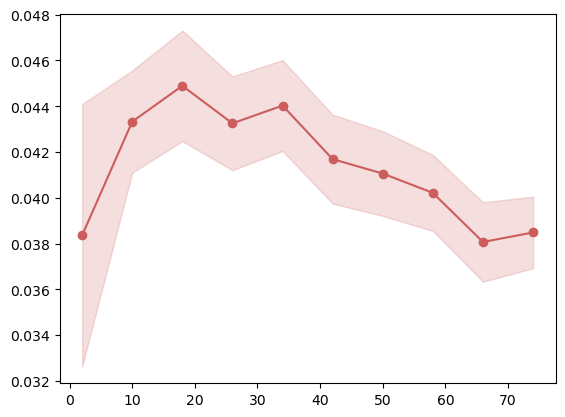

In [11]:
# parameters
tf = 40
n_steps = 5000
n_sims = 10**4
step_change = 4960
cnew = 90
N_arr = np.arange(2,80,8)
eps0 = -N_arr*np.log((1+100/18)/(1+100/2900))
G_arr = (1/(1 + np.exp(eps0)*((1+cnew/18)/(1+cnew/2900))**N_arr) - 0.5)/np.log(100/cnew)

def norm_kernel(t,taur):
    return 1-np.exp(-t/taur)

kernel_parms = np.zeros(N_arr.size,dtype='float64')
kernel_sds = np.zeros_like(kernel_parms)

for n,N in enumerate(N_arr):
    # set baseline energy
    m0 = N*(0.5+0.5*np.log((1+100/18)/(1+100/2900)))
    
    # obtain data and fit
    all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,methylation=False,Nr=N)
    test = all_states/G_arr[n]
    
    # extract mean
    activity = np.mean(test[:,:,0],axis=0)
    
    # find response and shift time
    baseline = np.mean(activity[step_change-101:step_change-1])
    response = (activity[step_change-1:] - baseline)/np.log(100/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sd_resp = np.std(test[:,step_change-1:,0],axis=0)/np.log(100/cnew)
    
    # perform fitting
    popt, pcov = curve_fit(norm_kernel,shifted_time,response,p0=[0.06],sigma=sd_resp)
    
    # show the fit
    color = colormap((n+1)/N_arr.size)
    plt.plot(shifted_time,norm_kernel(shifted_time,*popt),color=color,label=f'$N={N}$')
    plt.plot(shifted_time,response,'.',color=color,alpha=0.2)
        
    # store gain and response time
    kernel_parms[n] = popt
    kernel_sds[n] = np.sqrt(pcov[0,0])
    
plt.show()

plt.plot(N_arr,kernel_parms,'-o',color=my_red)
plt.fill_between(N_arr,kernel_parms-kernel_sds,kernel_parms+kernel_sds,
                    alpha=0.2,color=my_red)
plt.show()

# plt.plot(N_arr,kernel_parms[1,:],'-o',color=my_red)
# plt.fill_between(N_arr,kernel_parms[1,:]-kernel_sds[1,:],kernel_parms[1,:]+kernel_sds[1,:],
#                     alpha=0.2,color=my_red)
# plt.show()   

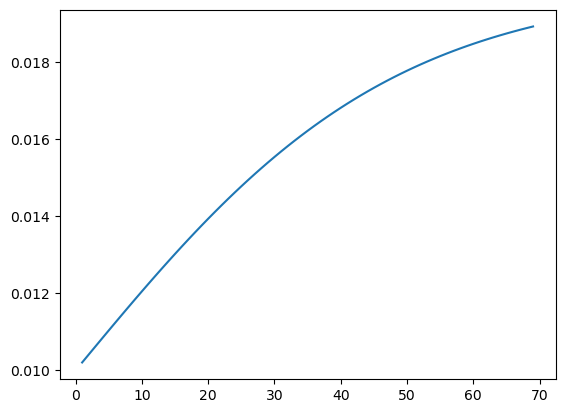

In [112]:
def theoretical_tau_r(N,c,c0=100,Ki=18,Ka=2900,kact=50):
    eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka))
    F = N*np.log((1+c/Ki)/(1+c/Ka)) + eps0
    return 1/(kact*(1+np.exp(F)))

c = 95
N_test = np.arange(1,70)

plt.plot(N_test,theoretical_tau_r(N_test,c))
plt.show()

In [54]:
@numba.jit(nopython=True)

# function for finding several realisations of single-cell activity
def activity_finder(n_steps,tf,n_samples,N,Nc,m0=8.,meth_bool=True,c=100):
    # array to save results
    all_act = np.zeros((n_steps+1,n_samples))
    step_change = n_steps + 2
    
    for sample in range(n_samples):
        # obtain a realisation
        all_states, results, time = gillespie_nolig(m0,tf,n_steps,Nc,step_change,c,Nr=N,methylation=meth_bool)
        
        # store only the activity
        all_act[:,sample] = results[:,0]
        
    return all_act, time

# function for finding autocorrelator of a time series; not in Numba mode!
def autocorr(all_act,time,co):
    # obtain average of product
    ata0_av = np.mean(all_act[co:,:]*all_act[co,:],axis=1)
    
    # obtain factors for product of averages
    at_av = np.mean(all_act[co:,:],axis=1)
    a0_av = np.mean(all_act[co,:])
    
    # shift time
    time_s = time[co:] - time[co]
    
    # return the autocorrelator: average of product minus product of averages
    return ata0_av-at_av*a0_av, time_s

[0.17392259 0.0091205 ]
[0.16805894 0.00938885]
[0.16627421 0.00957674]
[0.17125708 0.01008692]
[0.16557612 0.01070958]
[0.16203864 0.01119098]


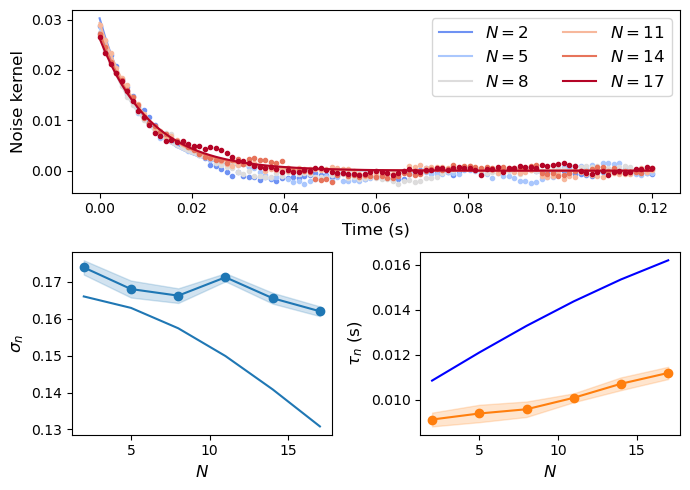

In [115]:
# figure preparation
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# parameters
n_steps = 25000
tf = 30
co = n_steps - 100
n_samples = 10**3
N_arr = np.arange(2,20,3)
Nc = 9
c = 90

# fitting function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# theoretical value of sigma
def theory_sigma_1(N,c,Ki=18,Ka=2900,c0=100):
    eps0 = -N*np.log((1+c0/Ki)/(1+c0/Ka))
    f = N*np.log((1+c/Ki)/(1+c/Ka)) + eps0
    P_A = 1/(1+np.exp(f))
    return np.sqrt(P_A*(1-P_A))
    
# store results
noise_parms = np.zeros((2,N_arr.size),dtype='float32')
noise_sds = np.zeros_like(noise_parms)

for n,N in enumerate(N_arr):
    # set baseline energy
    m0 = N*(0.5+0.5*np.log((1+100/18)/(1+100/2900)))
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc,m0=m0,meth_bool=False,c=c)

    # compute autocorrelator and perform fit
    auto_corr, time_s = autocorr(all_act,time,co)
    popt_n, pcov_n = curve_fit(noise_fit,time_s,auto_corr)
    print(popt_n)
    noise_parms[:,n] = popt_n
    noise_sds[:,n] = [np.sqrt(pcov_n[i,i]) for i in range(2)]
    
    # plot the results
    color = colormap((n+1)/N_arr.size)
    ax1.plot(time_s,auto_corr,'.',color=color,alpha=1)
    ax1.plot(time_s,noise_fit(time_s,*popt_n),color=color,label=f'$N={N}$')
    
ax1.legend(ncol=2,fontsize=12)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)

for i,ax in enumerate((ax2,ax3)):
    ax.plot(N_arr,noise_parms[i,:],'-o',color=colormap_2(i))
    ax.fill_between(N_arr,noise_parms[i,:]-noise_sds[i,:],noise_parms[i,:]+noise_sds[i,:],
                    color=colormap_2(i),alpha=0.2)
    ax.set_xlabel(r'$N$',size=12)

#ax2.axhline(y=0.5/np.sqrt(Nc),xmin=0.02,xmax=0.98,ls='--',color='r')
ax2.plot(N_arr,theory_sigma_1(N_arr,c)/np.sqrt(Nc))
ax2.set_ylabel(r'$\sigma_n$',size=12)
ax3.plot(N_arr,theory_tau_r(N_arr,c),color='b')
ax3.set_ylabel(r'$\tau_n$ (s)',size=12)

plt.tight_layout()
plt.show()

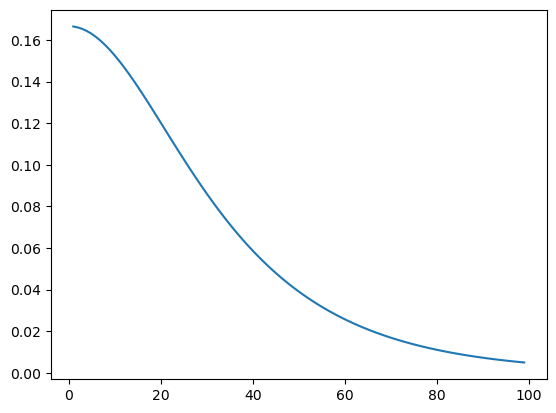

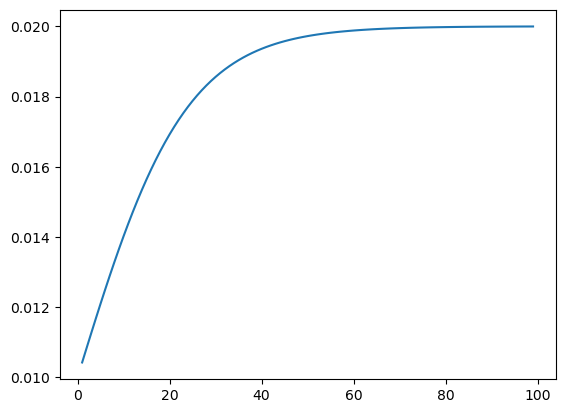

In [114]:
test = np.arange(1,100)
plt.plot(test,theory_sigma_1(test,90)/np.sqrt(Nc))
plt.show()

plt.plot(test,theory_tau_r(test,90))
plt.show()



## Fitting to Extract Response and Adaptation Timescale

This part uses a model proposed by Mattingly et al. (2021) for the shape of the response curve as

$$ K(t) = G \exp\{-t/\tau_2\}(1 - \exp\{-t/\tau_1\})H(t), $$

where $K(t)$ is the response, $G$ is the gain or amplitude, $\tau_1$ is the rise time, $\tau_2$ is the adaptation time and $H(t)$ is the Heaviside step function. Note that we have subtracted the baseline activity and set $t=0$ when the concentration is increased. Furthermore, Mattingly et al. only probed responses for a 10% increase or decrease in concentration, starting from a background of 100 $\mu$M.

Additionally, this model is fitted to a rescaled version of the activity. Concretely, $K(t)$ is fitted to $a(t)/\log(c_0/c_f)$, where $c_f = 90 \, \mu$M is the final concentration and $c_0 = 100\,\mu$M is the baseline concentration.   

Ultimately, the aim of this section is to compare our fitting results to those of Mattingly et al. They find $G = 1.73 \pm 0.03$, $\tau_1 = 0.22 \pm 0.01$ s and $\tau_2 = 9.90 \pm 0.30$ s, so we would like to verify to what extent our simulations reproduce these features of their experiment.

In [15]:
# define model function
def mattingly_fit(t,G,tau1,tau2):
    return G*(1 - np.exp(-t/tau1))*np.exp(-t/tau2)

# function for extracting the response
def response_kernel(all_states,step_change,time,cnew=90,plot_bool=False):
    # extract mean
    activity = np.mean(all_states[:,:,0],axis=0)
    
    # find response and shift time
    baseline = np.mean(activity[step_change-1000:step_change])
    response = (activity[step_change-1:] - baseline)/np.log(100/cnew)
    shifted_time = time[step_change-1:] - time[step_change-1]
    
    # extract standard deviations of response
    sd_resp = np.std(all_states[:,step_change-1:,0],axis=0)/np.log(100/cnew)
    
    # perform fitting
    popt, pcov = curve_fit(mattingly_fit,shifted_time,response,p0=[0.7,0.1,10],sigma=sd_resp)
    
    # show plot if desired
    if plot_bool:
        plt.plot(shifted_time,response,'.',label='Simulation',color=my_red,alpha=0.05)
        plt.plot(shifted_time, mattingly_fit(shifted_time, *popt_lit),label='Fit',color=my_red)
        plt.xlabel('Time (s)')
        plt.ylabel('Response')
        plt.title(r'Fitting procedure for linear response function ($N=6, \; N_c = 400$)')
        plt.show()
        
    # return the fitting parameters and their uncertainties
    return response, shifted_time, popt, [np.sqrt(pcov[i,i]) for i in range(3)]

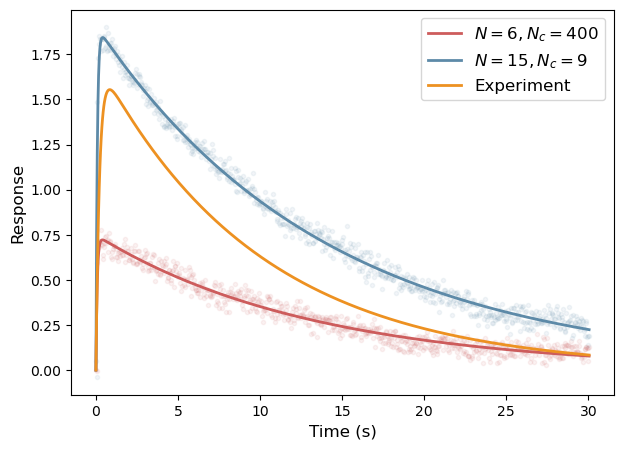

Literature values: [G, taur, taua] =  [ 0.74788124  0.07724332 13.26162944]  with sd =  [0.00487392761863768, 0.00623683064385145, 0.1288331096742332]
Adjusted values: [G, taur, taua] =  [ 1.90944979  0.08024928 14.01822163]  with sd =  [0.0063009444166611875, 0.003267364037242673, 0.0700049208339037]


In [16]:
# obtain nice data
m0 = 8.
tf = 400
n_steps = 10**4
n_sims = 10**4
step_change = 9250
cnew = 90

# obtain data for literature values 
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew)
response_lit, shifted_time, popt_lit, sds_lit = response_kernel(all_states,step_change,time)

# obtain data for adjusted values
all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,Nr=15)
response_adj, shifted_time, popt_adj, sds_adj = response_kernel(all_states,step_change,time)

# figure showing the different response kernels
fig = plt.figure(figsize=(7,5))

# literature values
plt.plot(shifted_time,mattingly_fit(shifted_time,*popt_lit),label=r'$N = 6, N_c = 400$',color=my_red,linewidth=2.0)
plt.plot(shifted_time,response_lit,'.',color=my_red,alpha=0.08)

# adjusted values
plt.plot(shifted_time,mattingly_fit(shifted_time,*popt_adj),label=r'$N = 15, N_c = 9$',color=my_blue,linewidth=2.0)
plt.plot(shifted_time,response_adj,'.',color=my_blue,alpha=0.08)

# experiment and formatting
plt.plot(shifted_time,mattingly_fit(shifted_time,1.73,0.22,9.90),label='Experiment',color=my_yellow,linewidth=2.0)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Response',size=12)
plt.legend(fontsize=12)
plt.show()

# report fitting results
print('Literature values: [G, taur, taua] = ', popt_lit,' with sd = ', sds_lit)
print('Adjusted values: [G, taur, taua] = ', popt_adj,' with sd = ', sds_adj)

### Interpretation

Our fit indicates time scales $\tau_1$ and $\tau_2$ for response and adaptation, respectively, similar to those found by Mattingly and colleagues. However, our estimate of $G$ is an order of magnitude lower than their experiments suggest. This aligns with Manuel's findings. Together, this indicates that our dynamical MWC does not reproduce the experiments by Mattingly et al. well, given the parameter values that are often used in the literature. Therefore, we assess whether changing the number of receptors per cluster ($N$) and number of clusters ($N_c$) removes the discrepancy between our simulations and their experiments. Concretely, we follow Manuel's suggestion to change $N$ from 6 to 15 and $N_c$ from 400 to 9. Note that while $N_c$ does not affect the procedure for finding $K(t)$, it does have a strong effect on the noise kernel (see below).

The fitted values for $N=15$ and $N_c = 9$ are in much better agreement with the experimental results by Mattingly et al., with $G$ in particular. For convenience, we show both the simulated fits as well as the fit obtained by Mattingly et al. in the plot below.

Parms: [ 0.71380912  0.07837301 14.84192989]
Parms: [ 0.77339054  0.08434055 13.58875723]
Parms: [ 0.77164622  0.08407747 13.21994375]
Parms: [ 0.80817308  0.08948988 12.61424882]
Parms: [ 0.73272445  0.08452689 11.61437905]


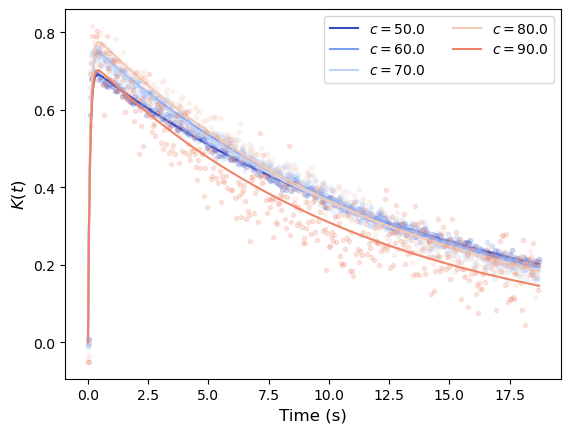

In [34]:
# check how the kernel depends on the concentration
cnew_arr = np.linspace(50,90,5)

# parameters
m0 = 8.
tf = 70
n_steps = 1500
n_sims = 5000
step_change = 1100

for k,cnew in enumerate(cnew_arr):
    # obtain data for adjusted values
    all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,Nr=6)
    response, shifted_time, popt, sds = response_kernel(all_states,step_change,time,cnew=cnew)
    
    print('Parms:',popt)
    
    # show data and fit
    plt.plot(shifted_time,response,'.',alpha=0.8,color=colormap(k/cnew_arr.size))
    plt.plot(shifted_time,mattingly_fit(shifted_time,*popt),
             color=colormap(k/cnew_arr.size),label=f'$c={np.round(cnew,2)}$')

plt.legend(ncol=cnew_arr.size//2)
plt.xlabel(r'Time (s)',size=12)
plt.ylabel(r'$K(t)$',size=12)
plt.show() 

Parms: [ 0.71756611  0.07543583 15.29317944]
Parms: [ 0.98945522  0.07466666 14.74852096]
Parms: [ 1.2872702   0.07229929 13.96615698]


/tmp/ipykernel_2920539/1386056682.py:3: RuntimeWarning: overflow encountered in exp
  return G*(1 - np.exp(-t/tau1))*np.exp(-t/tau2)


Parms: [ 1.5108766   0.06791395 13.92817507]
Parms: [ 1.84044533  0.08378707 12.79575533]
Parms: [ 2.09842765  0.07337976 13.74859787]


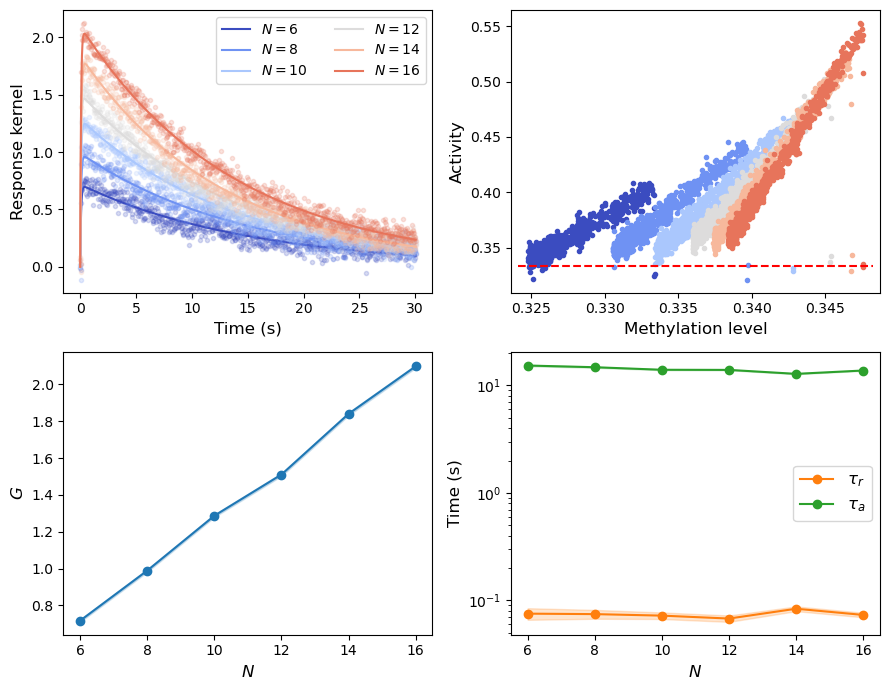

In [68]:
# figure preparation
fig = plt.figure(figsize=(9,7))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# check how the kernel depends on the cluster size
N_arr = np.array([6,8,10,12,14,16])
# parameters
m0 = 8.
tf = 400
n_steps = 10**4
n_sims = 5000
step_change = 9250
cnew = 90

adaptive_parms = np.zeros((3,N_arr.size),dtype='float32')
adaptive_sds = np.zeros_like(adaptive_parms)

for n,N in enumerate(N_arr):
    # obtain data for adjusted values
    all_states, results, time = gillespie_nolig(m0,tf,n_steps,n_sims,step_change,cnew,Nr=N)
    response, shifted_time, popt, sds = response_kernel(all_states,step_change,time,cnew=cnew)
    
    # save results
    adaptive_parms[:,n] = popt
    adaptive_sds[:,n] = sds
    
    print('Parms:',popt)
    
    # show data and fit
    ax1.plot(shifted_time,response,'.',alpha=0.2,color=colormap(n/N_arr.size))
    ax1.plot(shifted_time,mattingly_fit(shifted_time,*popt),
             color=colormap(n/N_arr.size),label=f'$N={N}$')
    
    # show phase portrait
    ax2.plot(results[step_change-1:,1],results[step_change-1:,0],'.',color=colormap(n/N_arr.size))

ax1.legend(ncol=N_arr.size//3)
ax1.set_xlabel(r'Time (s)',size=12)
ax1.set_ylabel(r'Response kernel',size=12)

ax2.set_xlabel('Methylation level',size=12)
ax2.set_ylabel('Activity',size=12)
ax2.axhline(y=1/3,xmin=0.02,xmax=0.98,ls='--',color='r')

labels = [r'$G$',r'$\tau_r$',r'$\tau_a$']

for i,ax in enumerate((ax3,ax4,ax4)):
    ax.plot(N_arr,adaptive_parms[i,:],'-o',color=colormap_2(i),label=labels[i])
    ax.fill_between(N_arr,adaptive_parms[i,:]-adaptive_sds[i,:],adaptive_parms[i,:]+adaptive_sds[i,:],
                   color=colormap_2(i),alpha=0.2)
    ax.set_xlabel(r'$N$',size=12)

ax3.set_ylabel(r'$G$',size=12)
ax4.set_ylabel('Time (s)',size=12)
ax4.legend(fontsize=12)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

[ 0.26001011 23.59097624]
[ 0.30784405 19.13521759]
[ 0.31953074 14.89843996]
[ 0.30119409 13.30734874]
[ 0.28551624 13.03515686]
[ 0.26669922 13.19827775]
[ 0.25499226 15.33848638]
[ 0.19955618 17.59211042]
[ 0.13131676 36.03840625]
[ 0.06781558 40.89829935]


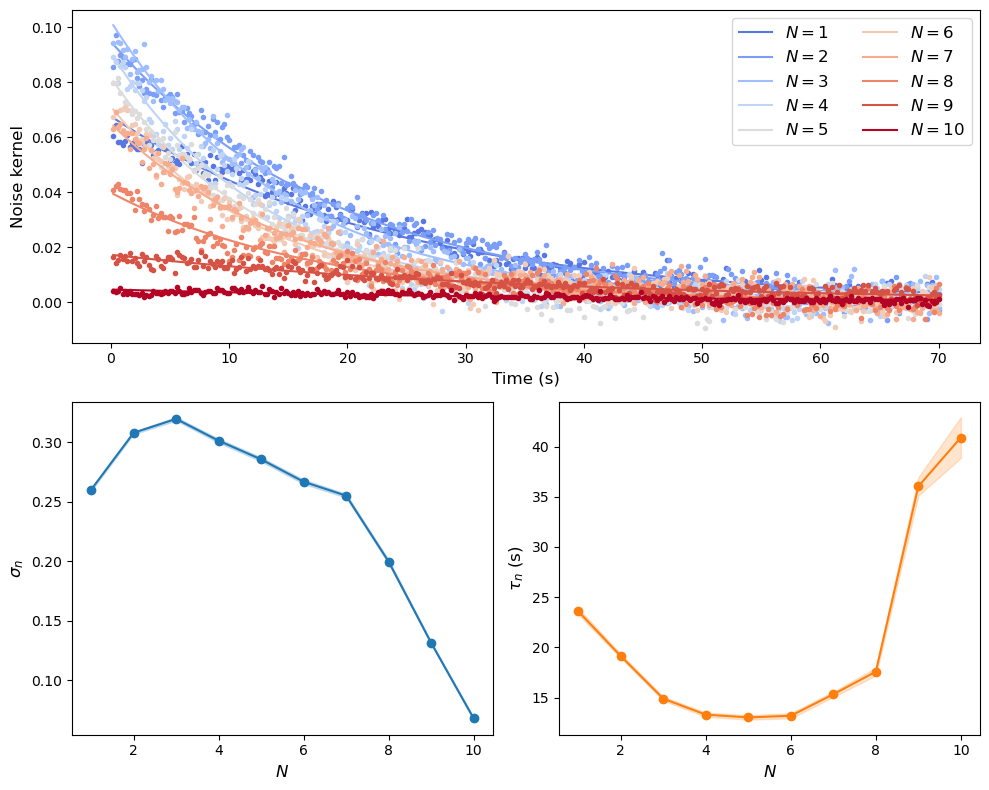

In [139]:
# figure preparation
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# parameters
n_steps = 500
tf = 100
co = n_steps - 350
n_samples = 3000
N_arr = np.arange(1,11)
Nc = 1
c = 100

# fitting function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)
    
# store results
anoise_parms = np.zeros((2,N_arr.size),dtype='float32')
anoise_sds = np.zeros_like(anoise_parms)

for n,N in enumerate(N_arr):
    # set intial condition close to equilibrium
    m0 = 8.
    
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc,m0=m0,meth_bool=True,c=c)

    # compute autocorrelator and delete first point for fit
    auto_corr, time_s = autocorr(all_act,time,co)
    
    popt_na, pcov_na = curve_fit(noise_fit,time_s[1:],auto_corr[1:])
    print(popt_na)
    anoise_parms[:,n] = popt_na
    anoise_sds[:,n] = [np.sqrt(pcov_na[i,i]) for i in range(2)]
    
    # plot the results
    color = colormap((n+1)/N_arr.size)
    ax1.plot(time_s[1:],auto_corr[1:],'.',color=color,alpha=1)
    ax1.plot(time_s[1:],noise_fit(time_s[1:],*popt_na),color=color,label=f'$N={N}$')
    
ax1.legend(ncol=2,fontsize=12)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)

for i,ax in enumerate((ax2,ax3)):
    ax.plot(N_arr,anoise_parms[i,:],'-o',color=colormap_2(i))
    ax.fill_between(N_arr,anoise_parms[i,:]-anoise_sds[i,:],anoise_parms[i,:]+anoise_sds[i,:],
                    color=colormap_2(i),alpha=0.2)
    ax.set_xlabel(r'$N$',size=12)

#ax2.axhline(y=0.5/np.sqrt(Nc),xmin=0.02,xmax=0.98,ls='--',color='r')
#ax2.plot(N_arr,theory_sigma_1(N_arr,c)/np.sqrt(Nc))
ax2.set_ylabel(r'$\sigma_n$',size=12)
#ax3.plot(N_arr,theory_tau_r(N_arr,c),color='b')
ax3.set_ylabel(r'$\tau_n$ (s)',size=12)

plt.tight_layout()
plt.show()

## Noise kernel

Here we estimate the noise kernel in order to compare our results to Mattingly et al.'s work. The aim is to find the autocorrelator, which we do as follows. Firstly, we simulate a trajectory $a_i(t)$ on the cell level, meaning that it is averaged over $N_c = 400$ clusters. Since we are interested in the steady-state noise, the background concentration is kept constant at $c = 100\,\mu$M and the transient until reaching equilibrium is cut off. We repeat this procedure $N_s$ times to obtain the activities $a_1(t),...,a_{N_s}(t)$. The noise kernel is then defined as the autocorrelation of the activity with itself,

$$ N(t) \equiv \langle a(t)a(0) \rangle - \langle a(t) \rangle \langle a(0) \rangle, $$

with $t=0$ where the transient is cut off. Computing $N(t)$ thus requires taking ensemble averages over the sets $\{ a_1(t), ..., a_{N_s}(t)\}$, $\{a_1(0),...,a_{N_s}(0) \}$ and $\{a_1(t)a_1(0),...,a_{N_s}(t)a_{N_s}(0) \}$.

Measurements indicate that $x(t)$ is well approximated by an Ornstein-Uhlenbeck process, such that the noise kernel is of the form

$$ N(t) = \sigma_n^2 \exp\{-|t|/\tau_n\}, $$

where $\sigma_n$ sets the amplitude and $\tau_n$ the time scale of the fluctuations in $x(t)$. From their measurements, Mattingly et al. find that $\sigma_n = 0.092 \pm 0.002$ and $\tau_n = 11.75 \pm 0.04$ s, so the aim of this section is to check whether our simulations agree with these values.

Parameters of best fit: [sigma, tau_n] = [1.34146641e-02 1.45163859e+01]
Standard deviations: [6.839533664362046e-05, 0.23548262024735717]
Parameters of best fit: [sigma, tau_n] = [ 0.09005035 14.30122811]
Standard deviations: [0.0005266701485441322, 0.26483751562300345]


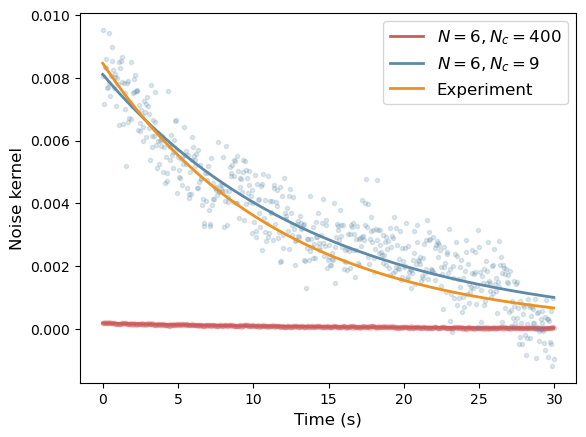

In [18]:
# set parameters for long-term noise kernel
n_steps = 2000
tf = 100
n_samples = 10**3
co = 1400

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# find noise kernel for literature and adjusted values
for i in range(2):
    if i == 0:
        # literature case
        label = r'$N = 6, N_c=400$'
        N = 6
        Nc = 400
        color = my_red
    else:
        # adjusted values
        label = r'$N = 6, N_c=9$'
        N = 6 ############################### check this
        Nc = 9
        color = my_blue

    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # ignore the first point
    auto_corr_nofirst = auto_corr[1:]
    time_s_nofirst = time_s[1:] - time_s[1]

    # perform fitting
    popt_n, pcov_n = curve_fit(noise_fit,time_s_nofirst,auto_corr_nofirst)

    print('Parameters of best fit: [sigma, tau_n] =', popt_n)
    print('Standard deviations:', [np.sqrt(pcov_n[i,i]) for i in range(2)])

    # show results, including the zero-lag time point
    plt.plot(time_s_nofirst,auto_corr_nofirst,'.',color=color,alpha=0.2)
    plt.plot(time_s_nofirst,noise_fit(time_s_nofirst,*popt_n),label=label,color=color,linewidth=2.0)
    
plt.plot(time_s_nofirst,noise_fit(time_s_nofirst,0.092,11.75),label='Experiment',color=my_yellow,linewidth=2.0)
plt.xlabel('Time (s)',size=12)
plt.ylabel('Noise kernel',size=12)
plt.legend(fontsize=12)

plt.show()

Parameters of best fit: [sigma, tau_n] = [ 0.09067891 13.90983645]
Standard deviations: [0.0002110972860373518, 0.10164810690180674]
Parameters of best fit: [sigma, tau_n] = [ 0.09040471 12.76210598]
Standard deviations: [0.000281226591713326, 0.12165863079384688]
Parameters of best fit: [sigma, tau_n] = [ 0.08846919 13.36740238]
Standard deviations: [0.0002342992805305849, 0.10984339716760239]
Parameters of best fit: [sigma, tau_n] = [ 0.08828217 14.12621495]
Standard deviations: [0.00020830288892104636, 0.10512687338678997]
Parameters of best fit: [sigma, tau_n] = [ 0.08718393 12.7817083 ]
Standard deviations: [0.00021934711656073846, 0.0985850868176229]


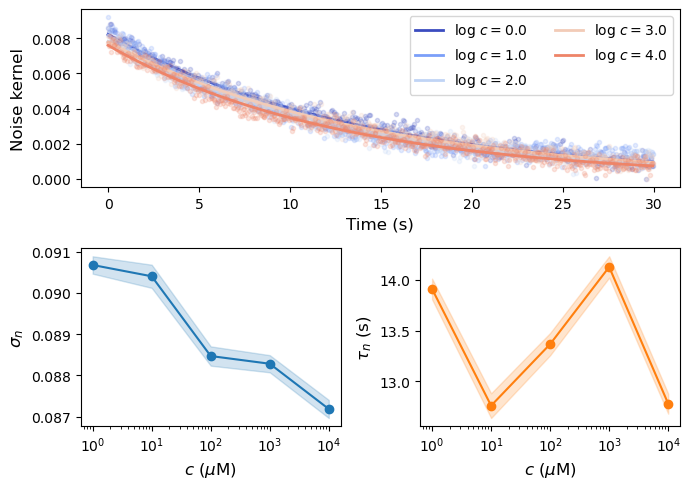

In [66]:
# figure preparation
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# check how the noise kernel depends on concentration
c_arr = np.logspace(0.,4.,5)

# set parameters for long-term noise kernel
n_steps = 2000
tf = 100
n_samples = 5000
co = 1400
N = 6
Nc = 9

# arrays to store results
adap_noise_parms = np.zeros((2,c_arr.size),dtype='float64')
adap_noise_sds = np.zeros_like(adap_noise_parms)

# find noise kernel for literature and adjusted values
for k,c in enumerate(c_arr):
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc,c=c)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # ignore the first point
    auto_corr_nofirst = auto_corr[1:]
    time_s_nofirst = time_s[1:] - time_s[1]

    # perform fitting
    popt_n, pcov_n = curve_fit(noise_fit,time_s_nofirst,auto_corr_nofirst)
    adap_noise_parms[:,k] = popt_n
    adap_noise_sds[:,k] = [np.sqrt(pcov_n[i,i]) for i in range(2)]

    print('Parameters of best fit: [sigma, tau_n] =', popt_n)
    print('Standard deviations:', [np.sqrt(pcov_n[i,i]) for i in range(2)])

    # show results, excluding the zero-lag time point
    ax1.plot(time_s_nofirst,auto_corr_nofirst,'.',color=colormap(k/c_arr.size),alpha=0.2)
    ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,*popt_n),
             label=f'log $c={np.round(np.log10(c),1)}$',color=colormap(k/c_arr.size),linewidth=2.0)
    
#plt.plot(time_s_nofirst,noise_fit(time_s_nofirst,0.092,11.75),label='Experiment',color=my_yellow,linewidth=2.0)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)
ax1.legend(fontsize=10,ncol=c_arr.size//2)

# show the fitting parameters
for i,ax in enumerate((ax2,ax3)):
    ax.semilogx(c_arr,adap_noise_parms[i,:],'-o',color=colormap_2(i))
    ax.fill_between(c_arr,adap_noise_parms[i,:]-adap_noise_sds[i,:],
                    adap_noise_parms[i,:]+adap_noise_sds[i,:],color=colormap_2(i),alpha=0.2)
    ax.set_xlabel(r'$c$ ($\mu$M)',size=12)
    
ax2.set_ylabel(r'$\sigma_n$',size=12)
ax3.set_ylabel(r'$\tau_n$ (s)',size=12)

plt.tight_layout()
plt.show()

Parameters of best fit: [sigma, tau_n] = [ 0.0906229  12.54187271]
Standard deviations: [0.00024121957186322828, 0.10185846884724258]
Parameters of best fit: [sigma, tau_n] = [ 0.08993328 13.00152821]
Standard deviations: [0.00020496851533287545, 0.09124739408859214]
Parameters of best fit: [sigma, tau_n] = [ 0.09160311 14.43337815]
Standard deviations: [0.00021800597431031863, 0.10908517999248583]
Parameters of best fit: [sigma, tau_n] = [ 0.07314441 22.32638908]
Standard deviations: [0.00016075206012652462, 0.18916877368011017]
Parameters of best fit: [sigma, tau_n] = [4.23027703e-02 4.39336684e+01]
Standard deviations: [9.385766778919608e-05, 0.5988847255485954]
Parameters of best fit: [sigma, tau_n] = [1.48943217e-02 9.14475067e+01]
Standard deviations: [5.779800080158903e-05, 4.092279595654506]
Parameters of best fit: [sigma, tau_n] = [2.96201641e-03 2.34950840e+08]
Standard deviations: [5.219075460651868e-05, 65482538189719.086]
Parameters of best fit: [sigma, tau_n] = [9.5774581

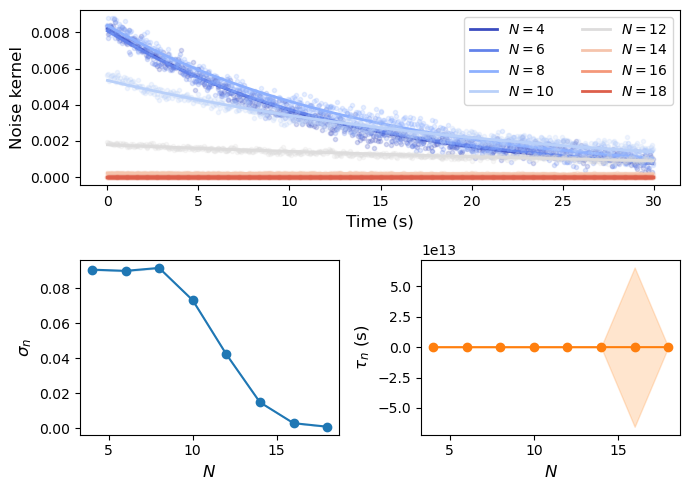

In [67]:
# figure preparation
fig = plt.figure(figsize=(7,5))
gs = gridspec.GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

# check how the noise kernel depends on cluster size
N_arr = np.array([4,6,8,10,12,14,16])

# set parameters for long-term noise kernel
n_steps = 2000
tf = 100
n_samples = 5000
co = 1400
c = 100
Nc = 9

# arrays to store results
adap_noise_parms = np.zeros((2,N_arr.size),dtype='float64')
adap_noise_sds = np.zeros_like(adap_noise_parms)

# find noise kernel for literature and adjusted values
for n,N in enumerate(N_arr):
    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc,c=c)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # ignore the first point
    auto_corr_nofirst = auto_corr[1:]
    time_s_nofirst = time_s[1:] - time_s[1]

    # perform fitting
    popt_n, pcov_n = curve_fit(noise_fit,time_s_nofirst,auto_corr_nofirst)
    adap_noise_parms[:,n] = popt_n
    adap_noise_sds[:,n] = [np.sqrt(pcov_n[i,i]) for i in range(2)]

    print('Parameters of best fit: [sigma, tau_n] =', popt_n)
    print('Standard deviations:', [np.sqrt(pcov_n[i,i]) for i in range(2)])

    # show results, excluding the zero-lag time point
    ax1.plot(time_s_nofirst,auto_corr_nofirst,'.',color=colormap(n/N_arr.size),alpha=0.2)
    ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,*popt_n),
             label=f'$N={N}$',color=colormap(n/N_arr.size),linewidth=2.0)
    
#plt.plot(time_s_nofirst,noise_fit(time_s_nofirst,0.092,11.75),label='Experiment',color=my_yellow,linewidth=2.0)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)
ax1.legend(fontsize=10,ncol=c_arr.size//2)

# show the fitting parameters
for i,ax in enumerate((ax2,ax3)):
    ax.plot(N_arr,adap_noise_parms[i,:],'-o',color=colormap_2(i))
    ax.fill_between(N_arr,adap_noise_parms[i,:]-adap_noise_sds[i,:],
                    adap_noise_parms[i,:]+adap_noise_sds[i,:],color=colormap_2(i),alpha=0.2)
    ax.set_xlabel(r'$N$',size=12)
    
ax2.set_ylabel(r'$\sigma_n$',size=12)
ax3.set_ylabel(r'$\tau_n$ (s)',size=12)

plt.tight_layout()
plt.show()

Parameters of best fit: [sigma, tau_n] = [1.27717011e-02 1.75794631e+01]
Standard deviations: [7.432570843995761e-05, 0.35014425404419147]
Parameters of best fit: [sigma, tau_n] = [8.01274373e-03 1.87975544e+02]
Standard deviations: [0.00012028259691487061, 63.910904543024586]


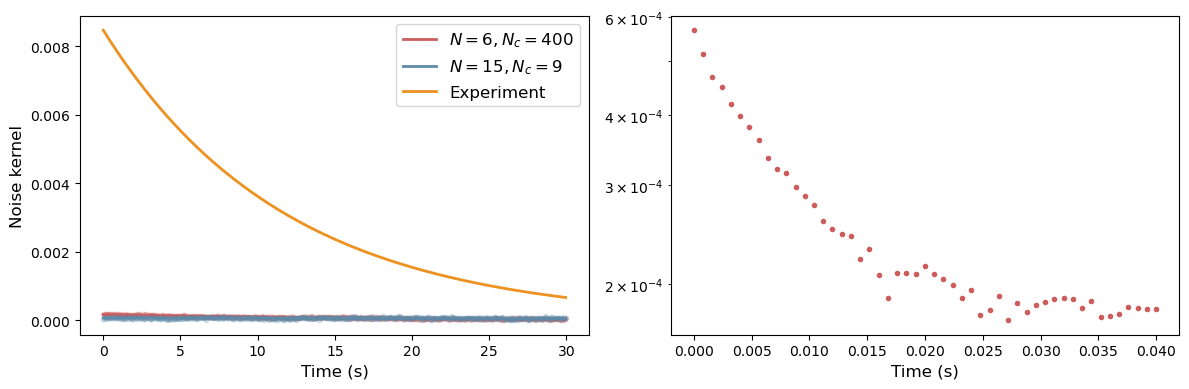

In [19]:
# set parameters for long-term noise kernel
n_steps = 2000
tf = 100
n_samples = 10**3
co = 1400

# define model function
def noise_fit(t,sigma,taun):
    return sigma**2*np.exp(-np.abs(t)/taun)

# prepare figure
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

# find noise kernel for literature and adjusted values
for i in range(2):
    if i == 0:
        # literature case
        label = r'$N = 6, N_c=400$'
        N = 6
        Nc = 400
        color = my_red
    else:
        # adjusted values
        label = r'$N = 15, N_c=9$'
        N = 15 ############################### check this
        Nc = 9
        color = my_blue

    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # ignore the first point
    auto_corr_nofirst = auto_corr[1:]
    time_s_nofirst = time_s[1:] - time_s[1]

    # perform fitting
    popt_n, pcov_n = curve_fit(noise_fit,time_s_nofirst,auto_corr_nofirst)

    print('Parameters of best fit: [sigma, tau_n] =', popt_n)
    print('Standard deviations:', [np.sqrt(pcov_n[i,i]) for i in range(2)])

    # show results, including the zero-lag time point
    ax1.plot(time_s_nofirst,auto_corr_nofirst,'.',color=color,alpha=0.2)
    ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,*popt_n),label=label,color=color,linewidth=2.0)
    
ax1.plot(time_s_nofirst,noise_fit(time_s_nofirst,0.092,11.75),label='Experiment',color=my_yellow,linewidth=2.0)
ax1.set_xlabel('Time (s)',size=12)
ax1.set_ylabel('Noise kernel',size=12)
ax1.legend(fontsize=12)

# reset parameters for short-term noise kernel
n_steps = 25000
tf = 20
co = 24950

# find noise kernel for literature and adjusted values
for i in range(2):
    if i == 0:
        # literature case
        label = r'$N = 6, N_c=400$'
        N = 6
        Nc = 400
        color = my_red
    else:
        # adjusted values
        label = r'$N = 15, N_c=9$'
        N = 15 ############################### check this
        Nc = 9
        color = my_blue

    # obtain activities
    all_act, time = activity_finder(n_steps,tf,n_samples,N,Nc)

    # compute autocorrelator
    auto_corr, time_s = autocorr(all_act,time,co)

    # show results
    ax2.plot(time_s,auto_corr,'.',color=color,alpha=1)
    
ax2.set_xlabel('Time (s)',size=12)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

### Interpretation

From our fitting procedure, we consistently find values of $\sigma_n$ that are roughly a factor of 10 below Mattingly et al.'s estimate. This agrees with Manuel's findings. Evidently, the dynamic MWC model does not reproduce the data by Mattingly et al. well given the parameters frequently used in the literature. Therefore, we check whether the agreement between simulations and experiment is better if we change the parameter values as suggested by Manuel, so we take $N=15$ and $N_c = 9$ instead of $N=6$ and $N_c=400$. 

Indeed, this makes our simulation and Mattingly's data agree very well. Also note that on very short time scales, the noise kernel behaves differently then expected for a simple Ornstein-Uhlenbeck process. In particular, the initial point is much higher than expected and there seems to be a fast decay before the slow regime takes over. We speculate that the slow decay time is set by the methylation time, whereas the fast regime stems from noise in the activity, which is on the time scale of 10-100 ms, in line with what we observe.